In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import importlib
warnings.filterwarnings('ignore')

In [2]:
from analysis.data.dataframe_creation import pipeline
sd = "2018-01-01"
ed = "2024-01-01"
dataset = pipeline(sd, ed)

[*********************100%***********************]  1 of 1 completed
[                       0%                       ]

Total number of tickers 502


[*********************100%***********************]  502 of 502 completed

6 Failed downloads:
['EIX']: ConnectionError(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))
['GEV', 'SOLV', 'SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1704085200")')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01)')



Null values: False
NaN values: False

Creating features
The dataset has 484 assets
The dataset has 16 predictors:
Ticker
Yavg_return
Yavg_volatility
beta
mkt_corr
Davg_span
Davg_volume
D_eSkewness
D_eVaR
D_eCVaR
D_eCurtosis
Sharpe_ratio
totalEsg
environmentScore
socialScore
governanceScore
industry


Dataset creation finished



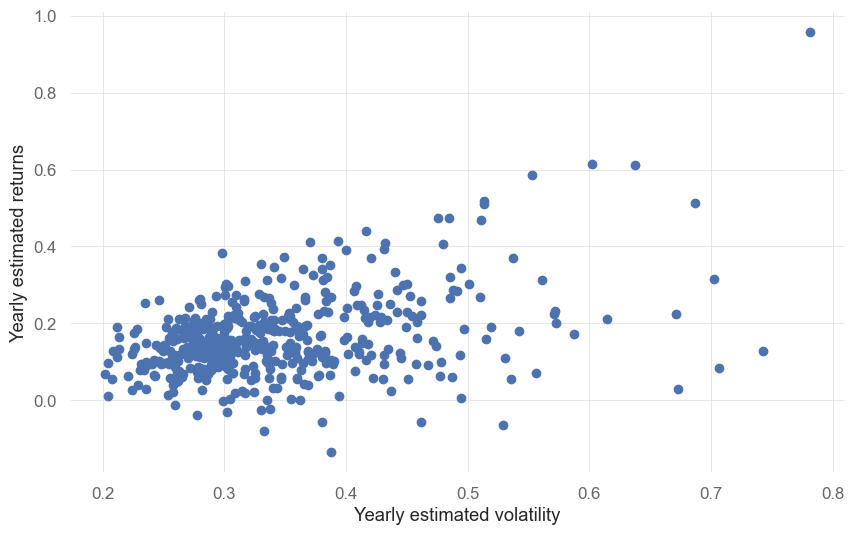

In [3]:
plt.scatter(dataset["Yavg_volatility"], dataset["Yavg_return"])
plt.xlabel("Yearly estimated volatility")
plt.ylabel("Yearly estimated returns")
plt.show()

In [3]:
outliers = outliers = dataset[
    (dataset["Yavg_return"] > 0.8)]["Ticker"].unique()
final_dataframe = dataset[~dataset["Ticker"].isin(outliers)]
final_dataframe.head()

,Ticker,Yavg_return,Yavg_volatility,beta,mkt_corr,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,industry
0,A,0.170255,0.290317,1.006774,0.707046,2.268208,1.961764e+06,-0.134994,-0.000283,-0.000401,4.334461,0.517553,11.36,1.19,6.23,3.93,Life Sciences Tools and Services
1,AAPL,0.309906,0.316770,1.238241,0.796984,2.378506,1.073273e+08,-0.036493,-0.000292,-0.000426,4.924362,0.915194,16.79,0.55,7.52,8.72,Technology
2,ABBV,0.159055,0.273195,0.657252,0.490510,2.003774,7.196053e+06,-0.845043,-0.000286,-0.000483,13.941098,0.508994,26.10,1.78,15.70,8.62,Biotechnology
3,ABT,0.155088,0.257788,0.853279,0.674864,1.733056,5.701730e+06,0.048219,-0.000290,-0.000434,6.096826,0.524026,22.21,1.81,13.84,6.56,Health Care
4,ACGL,0.204344,0.314158,0.979197,0.635493,0.905297,1.859299e+06,-0.321692,-0.000771,-0.001249,11.651915,0.586789,20.27,1.57,9.92,8.78,Insurance


In [4]:
stock_data_clustering = final_dataframe[["Yavg_return",	"Yavg_volatility"]]

stock_data_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 483 entries, 0 to 483
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Yavg_return      483 non-null    float64
 1   Yavg_volatility  483 non-null    float64
dtypes: float64(2)
memory usage: 11.3 KB


In [5]:
from sklearn.preprocessing import MinMaxScaler
for attr in stock_data_clustering.columns:
    scaler = MinMaxScaler()
    stock_data_clustering[attr] = scaler.fit_transform(stock_data_clustering[attr].values.reshape(-1, 1)).flatten()

In [6]:
from analysis.clustering.kmedoids_clustering import run_kmedoids
clusters = range(2, 25)
runs = 2
meanDistortions, sil_score, inertias = run_kmedoids(clusters, stock_data_clustering, runs)

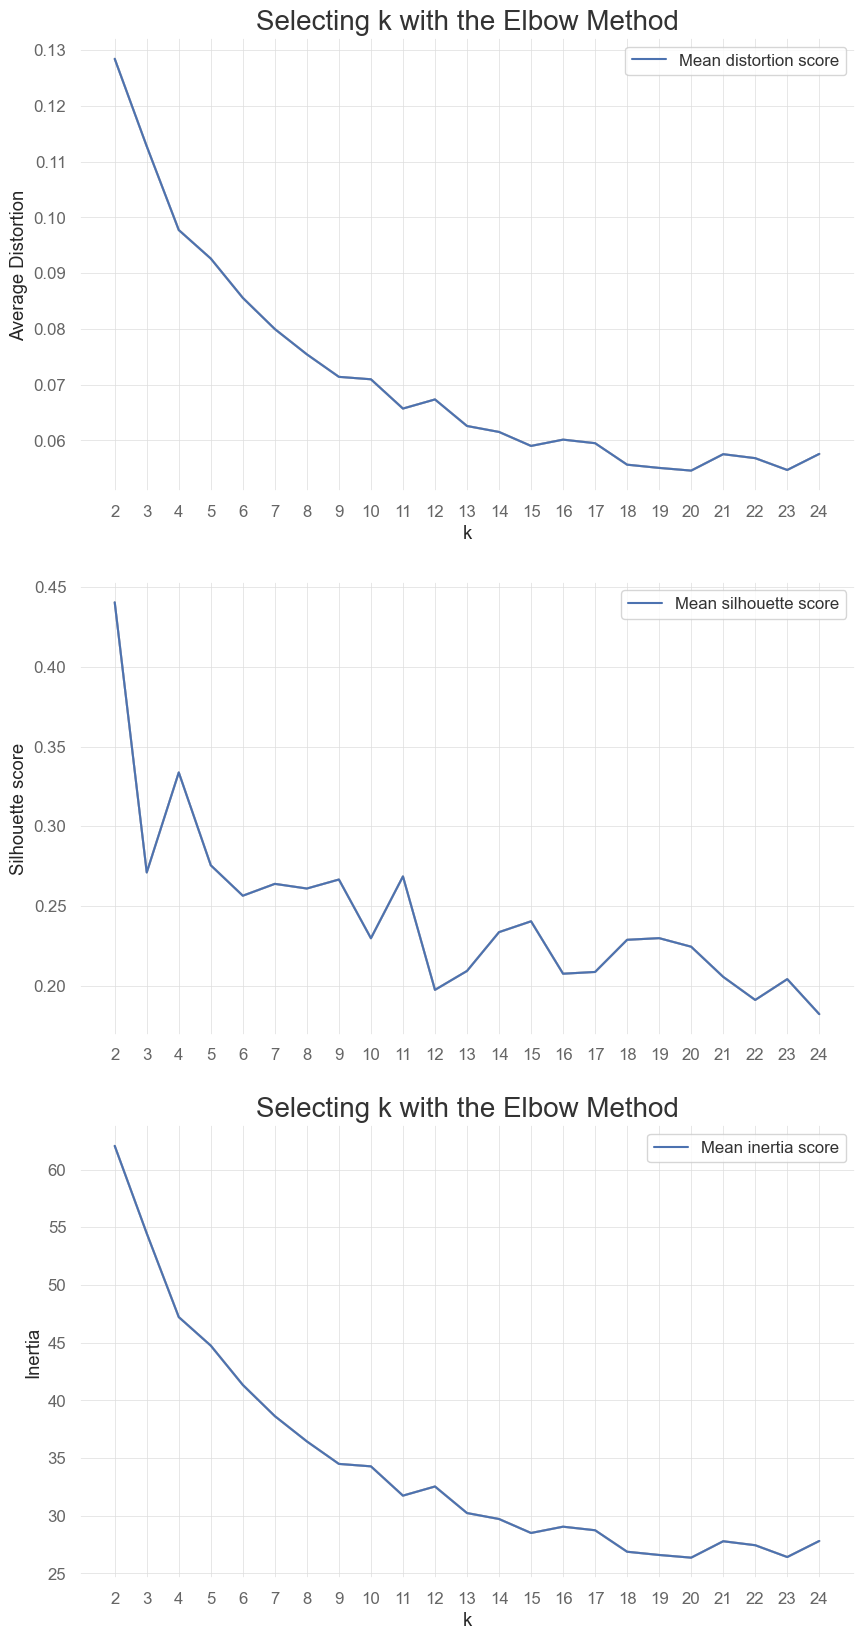

In [7]:
from analysis.data.plotting import plot_kmeans
plot_kmeans(runs, clusters, meanDistortions, sil_score, inertias)

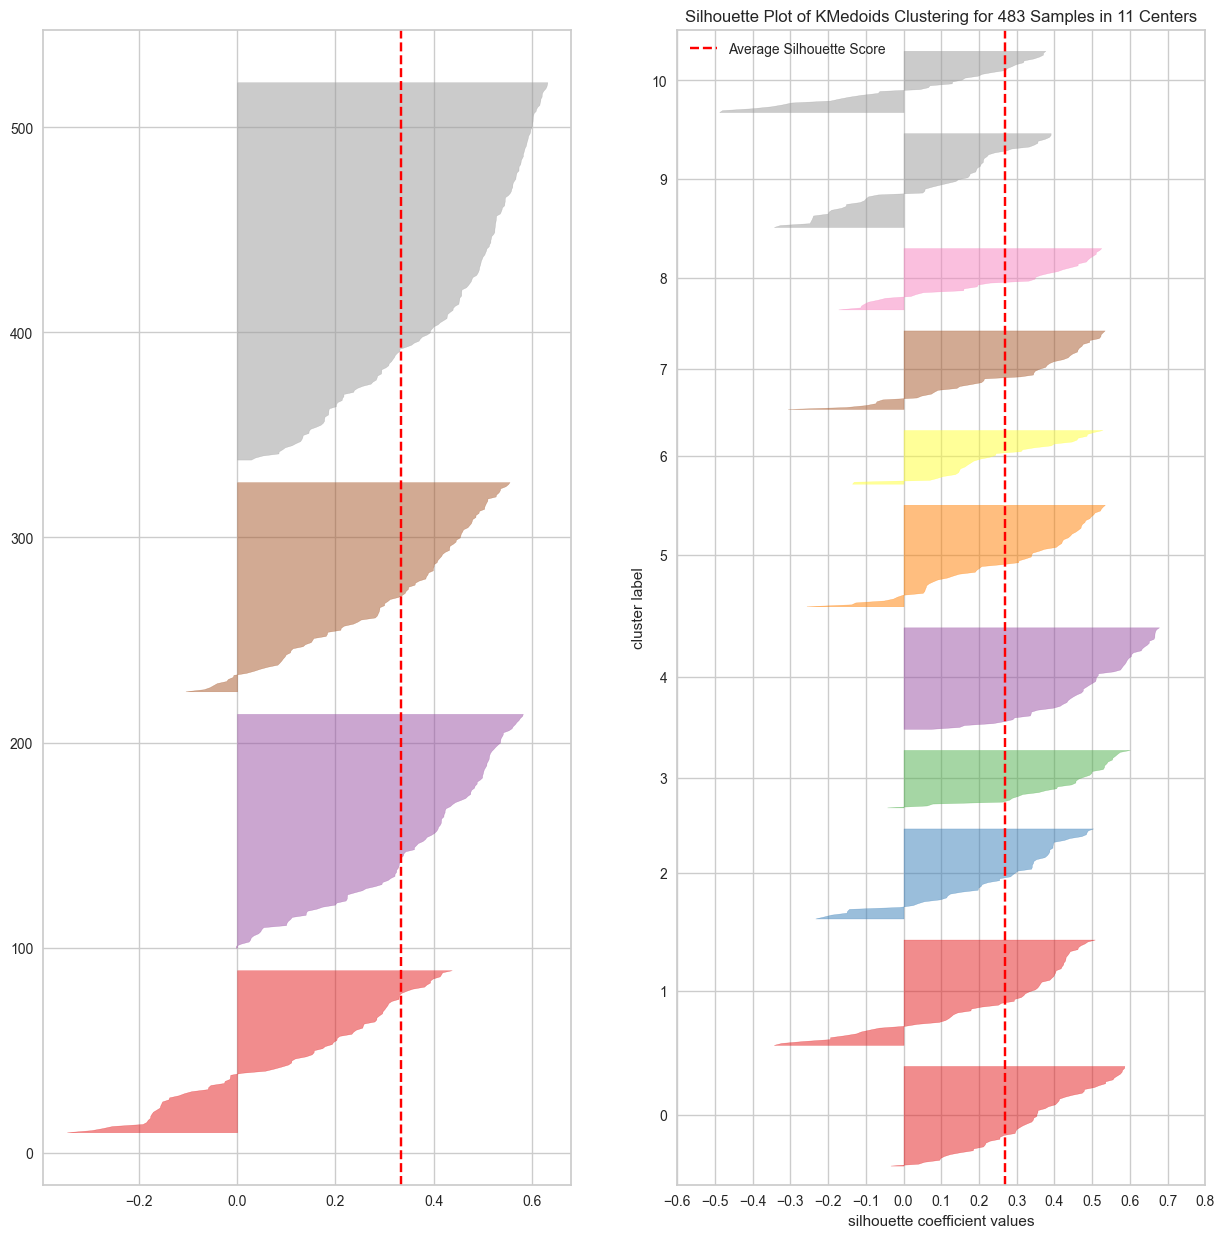

<Axes: title={'center': 'Silhouette Plot of KMedoids Clustering for 483 Samples in 11 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [9]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn_extra.cluster import KMedoids
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
visualizer = SilhouetteVisualizer(KMedoids(4, random_state=1))
visualizer.fit(stock_data_clustering)
plt.subplot(1,2,2)
visualizer = SilhouetteVisualizer(KMedoids(11, random_state=1))

visualizer.fit(stock_data_clustering)

visualizer.show()

In [26]:
N_SECTORS = 11

kmeans = KMedoids(n_clusters=N_SECTORS, random_state=0)
kmeans.fit(stock_data_clustering)
final_dataframe["Sector"] = kmeans.labels_
final_dataframe.head()

,Ticker,Yavg_return,Yavg_volatility,beta,mkt_corr,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,industry,Sector
0,A,0.170255,0.290317,1.006774,0.707046,2.268208,1.961764e+06,-0.134994,-0.000283,-0.000401,4.334461,0.517553,11.36,1.19,6.23,3.93,Life Sciences Tools and Services,4
1,AAPL,0.309906,0.316770,1.238241,0.796984,2.378506,1.073273e+08,-0.036493,-0.000292,-0.000426,4.924362,0.915194,16.79,0.55,7.52,8.72,Technology,8
2,ABBV,0.159055,0.273195,0.657252,0.490510,2.003774,7.196053e+06,-0.845043,-0.000286,-0.000483,13.941098,0.508994,26.10,1.78,15.70,8.62,Biotechnology,5
3,ABT,0.155088,0.257788,0.853279,0.674864,1.733056,5.701730e+06,0.048219,-0.000290,-0.000434,6.096826,0.524026,22.21,1.81,13.84,6.56,Health Care,1
4,ACGL,0.204344,0.314158,0.979197,0.635493,0.905297,1.859299e+06,-0.321692,-0.000771,-0.001249,11.651915,0.586789,20.27,1.57,9.92,8.78,Insurance,0


In [27]:
cluster_profile = final_dataframe.groupby("Sector").mean(numeric_only=True)

# Add counts for the number of stocks in each cluster
cluster_profile["Count"] = final_dataframe.groupby("Sector")["Ticker"].count().values
cluster_profile["Sharpe_ratio"] = (cluster_profile["Yavg_return"]-0.02)/cluster_profile["Yavg_volatility"]

max_cols = ["beta", "D_eSkewness", "Yavg_return", "Sharpe_ratio", "Davg_volume"]
min_cols = ["beta", "Davg_span", "D_eCurtosis", "Yavg_volatility", "D_eVaR", "D_eCVaR", 
            "totalEsg", "environmentScore", "socialScore", "governanceScore"]

# Custom function for styling
def highlight_extremes(val, col_name):
    max_color = "background-color: green"
    min_color = "background-color: blue"
    
    if col_name in max_cols and val == cluster_profile[col_name].max():
        return max_color
    elif col_name in min_cols and val == cluster_profile[col_name].min():
        return min_color
    return ""

cluster_profile.style.apply(lambda x: [highlight_extremes(v, x.name) for v in x], axis=0)
# cluster_profile.style.highlight_max(color="green", axis=0, subset=["beta", "D_eSkewness",	"Yavg_return", "Sharpe_ratio", "Davg_volume"])
# cluster_profile.style.highlight_min(color="green", axis=0, subset=["beta", "Davg_span", "D_eCurtosis",	"Yavg_volatility", "D_eVaR", "D_eCVaR", "totalEsg",	"environmentScore",	"socialScore",	"governanceScore"])

,Yavg_return,Yavg_volatility,beta,mkt_corr,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,Count
Sector,,,,,,,,,,,,,,,,
0,0.205320,0.340537,1.078273,0.644930,6.691239,4922954.401265,-0.029964,-0.000425,-0.000673,10.905822,0.544200,19.025577,4.470385,9.088846,5.466538,53
1,0.113618,0.248411,0.679430,0.556404,2.131047,3774754.781726,-0.194930,-0.000310,-0.000502,13.780844,0.376870,22.751964,7.367500,10.011250,5.372679,56
2,0.062259,0.274740,0.737252,0.540922,1.656535,5465001.677946,-0.335322,-0.000609,-0.000990,11.765947,0.153816,21.088125,6.462917,9.369583,5.256875,48
3,0.125108,0.339531,0.994649,0.598049,2.347690,5500314.337630,-0.073491,-0.000709,-0.001129,12.999425,0.309569,20.663000,5.816667,9.106333,5.740333,31
4,0.140949,0.297759,0.949545,0.650087,3.519938,2361478.216442,-0.057103,-0.000338,-0.000528,10.795836,0.406199,19.140926,5.487593,8.397222,5.255370,54
5,0.198242,0.273142,0.882889,0.659283,3.931693,2641395.036644,-0.111391,-0.000288,-0.000448,10.757025,0.652561,18.164630,4.314074,8.443333,5.406852,54
6,0.015092,0.339347,0.984714,0.589247,1.980443,4859997.094810,-0.169346,-0.000750,-0.001179,13.046054,-0.014462,21.902593,5.871852,9.761852,6.269259,29
7,0.115466,0.391988,1.190378,0.619791,1.743264,6822821.197498,-0.006139,-0.001078,-0.001695,11.757420,0.243542,19.351429,4.896190,8.428810,6.025952,42
8,0.320687,0.352056,1.127151,0.654187,4.495200,7745982.774324,0.164353,-0.000437,-0.000673,8.971790,0.854087,18.753333,4.077879,9.081818,5.593636,33


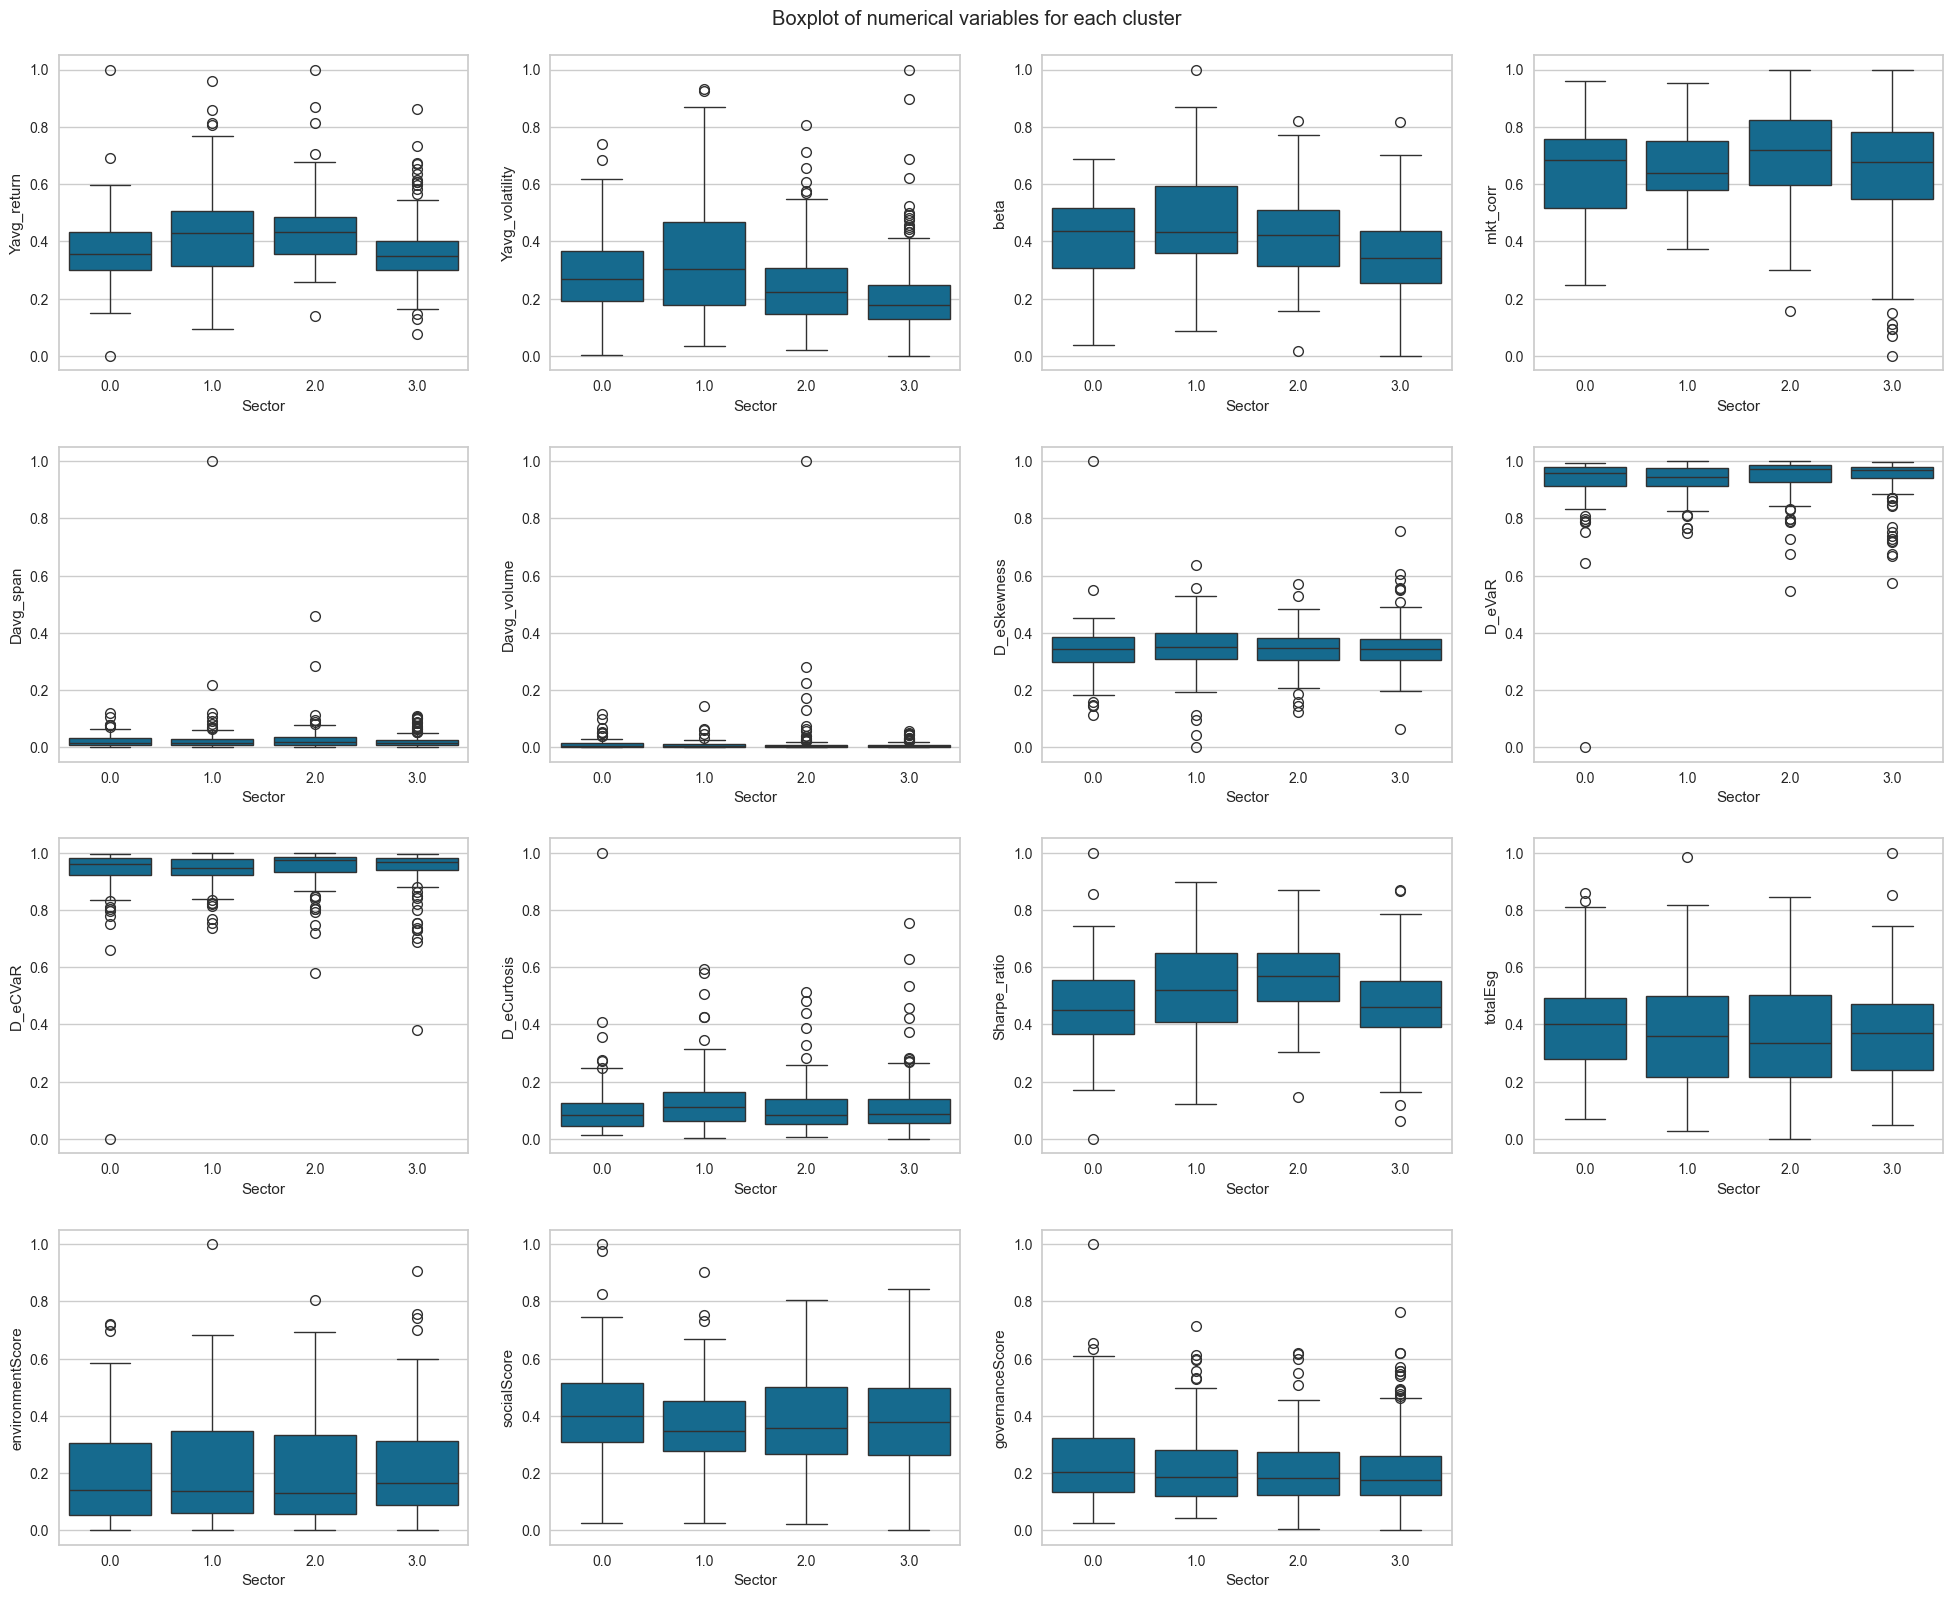

In [17]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaled_data = pd.DataFrame()
for attr in final_dataframe.select_dtypes(include=["float64", "int64"]).columns:
    scaler = MinMaxScaler()
    scaled_data[attr] = scaler.fit_transform(final_dataframe[attr].values.reshape(-1, 1)).flatten()
scaled_data["Sector"] = final_dataframe["Sector"]
plt.figure(figsize=(20, 20))
import seaborn as sns
plt.suptitle("Boxplot of numerical variables for each cluster")
i = 1
for i, variable in enumerate(final_dataframe):
  if variable not in ["Ticker", "industry", "Sector"]:
    plt.subplot(5, 4, i)
    sns.boxplot(data=scaled_data, x="Sector", y=variable)
    i += 1

plt.tight_layout(pad=2.0)

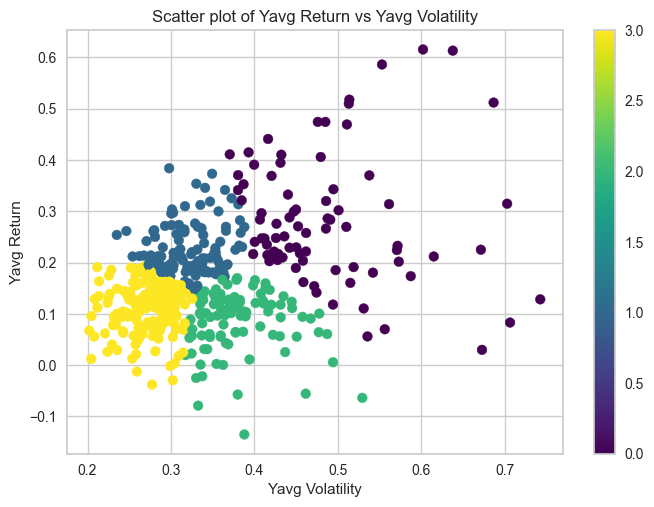

In [12]:
plt.scatter(
    final_dataframe["Yavg_volatility"], 
    final_dataframe["Yavg_return"], 
    c=final_dataframe["Sector"],  # Use c for color mapping
    cmap='viridis',  # Optional: Choose a colormap
    
)

# Add labels and title
plt.xlabel("Yavg Volatility")
plt.ylabel("Yavg Return")
plt.title("Scatter plot of Yavg Return vs Yavg Volatility")
plt.colorbar()
# Show the plot
plt.show()

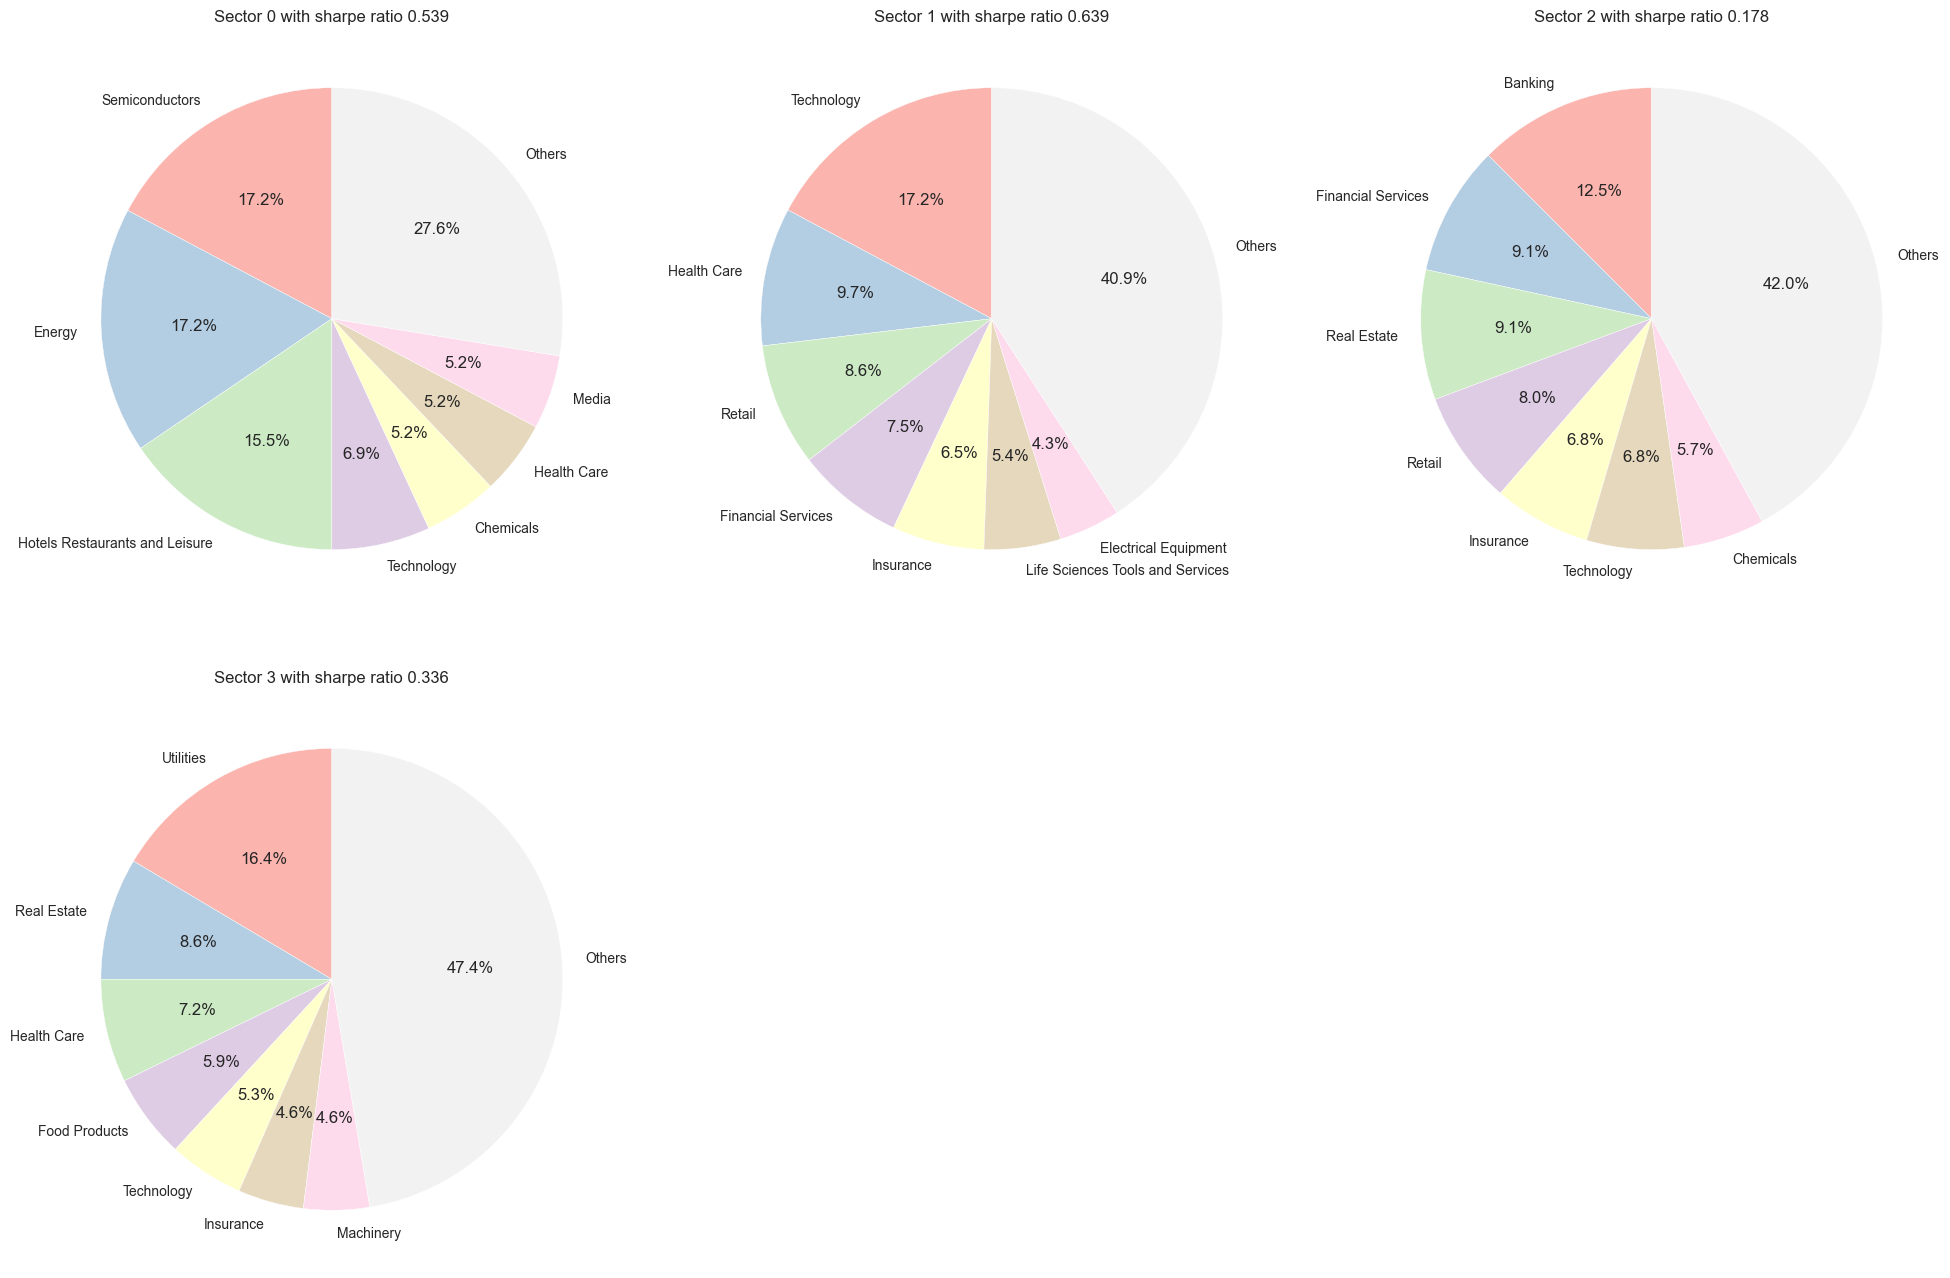

In [13]:
MAX_LABELS = 7
from analysis.data.plotting import plot_cluster_industry
plot_cluster_industry(MAX_LABELS, final_dataframe, cluster_profile)


In [ ]:
from analysis.data.dataframe_creation import create_portfolio_clustered
portfolio_ret, asset_ret = create_portfolio_clustered(sd, ed, final_dataframe,
                                                       list(final_dataframe["Ticker"]), w = "uniform")


[*********************100%***********************]  483 of 483 completed

1 Failed download:
['MHK']: ConnectionError(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))


Null values: False
Null values: False
Cluster Portfolios based on volatility


In [24]:
benchmark = yf.download(tickers="SPY", start=sd, end=ed, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


In [ ]:
import analysis.data.plotting as plotting
importlib.reload(plotting)
from analysis.data.plotting import portfolio_evolution_time
portfolio_evolution_time(portfolio_ret.reset_index(), benchmark.reset_index())

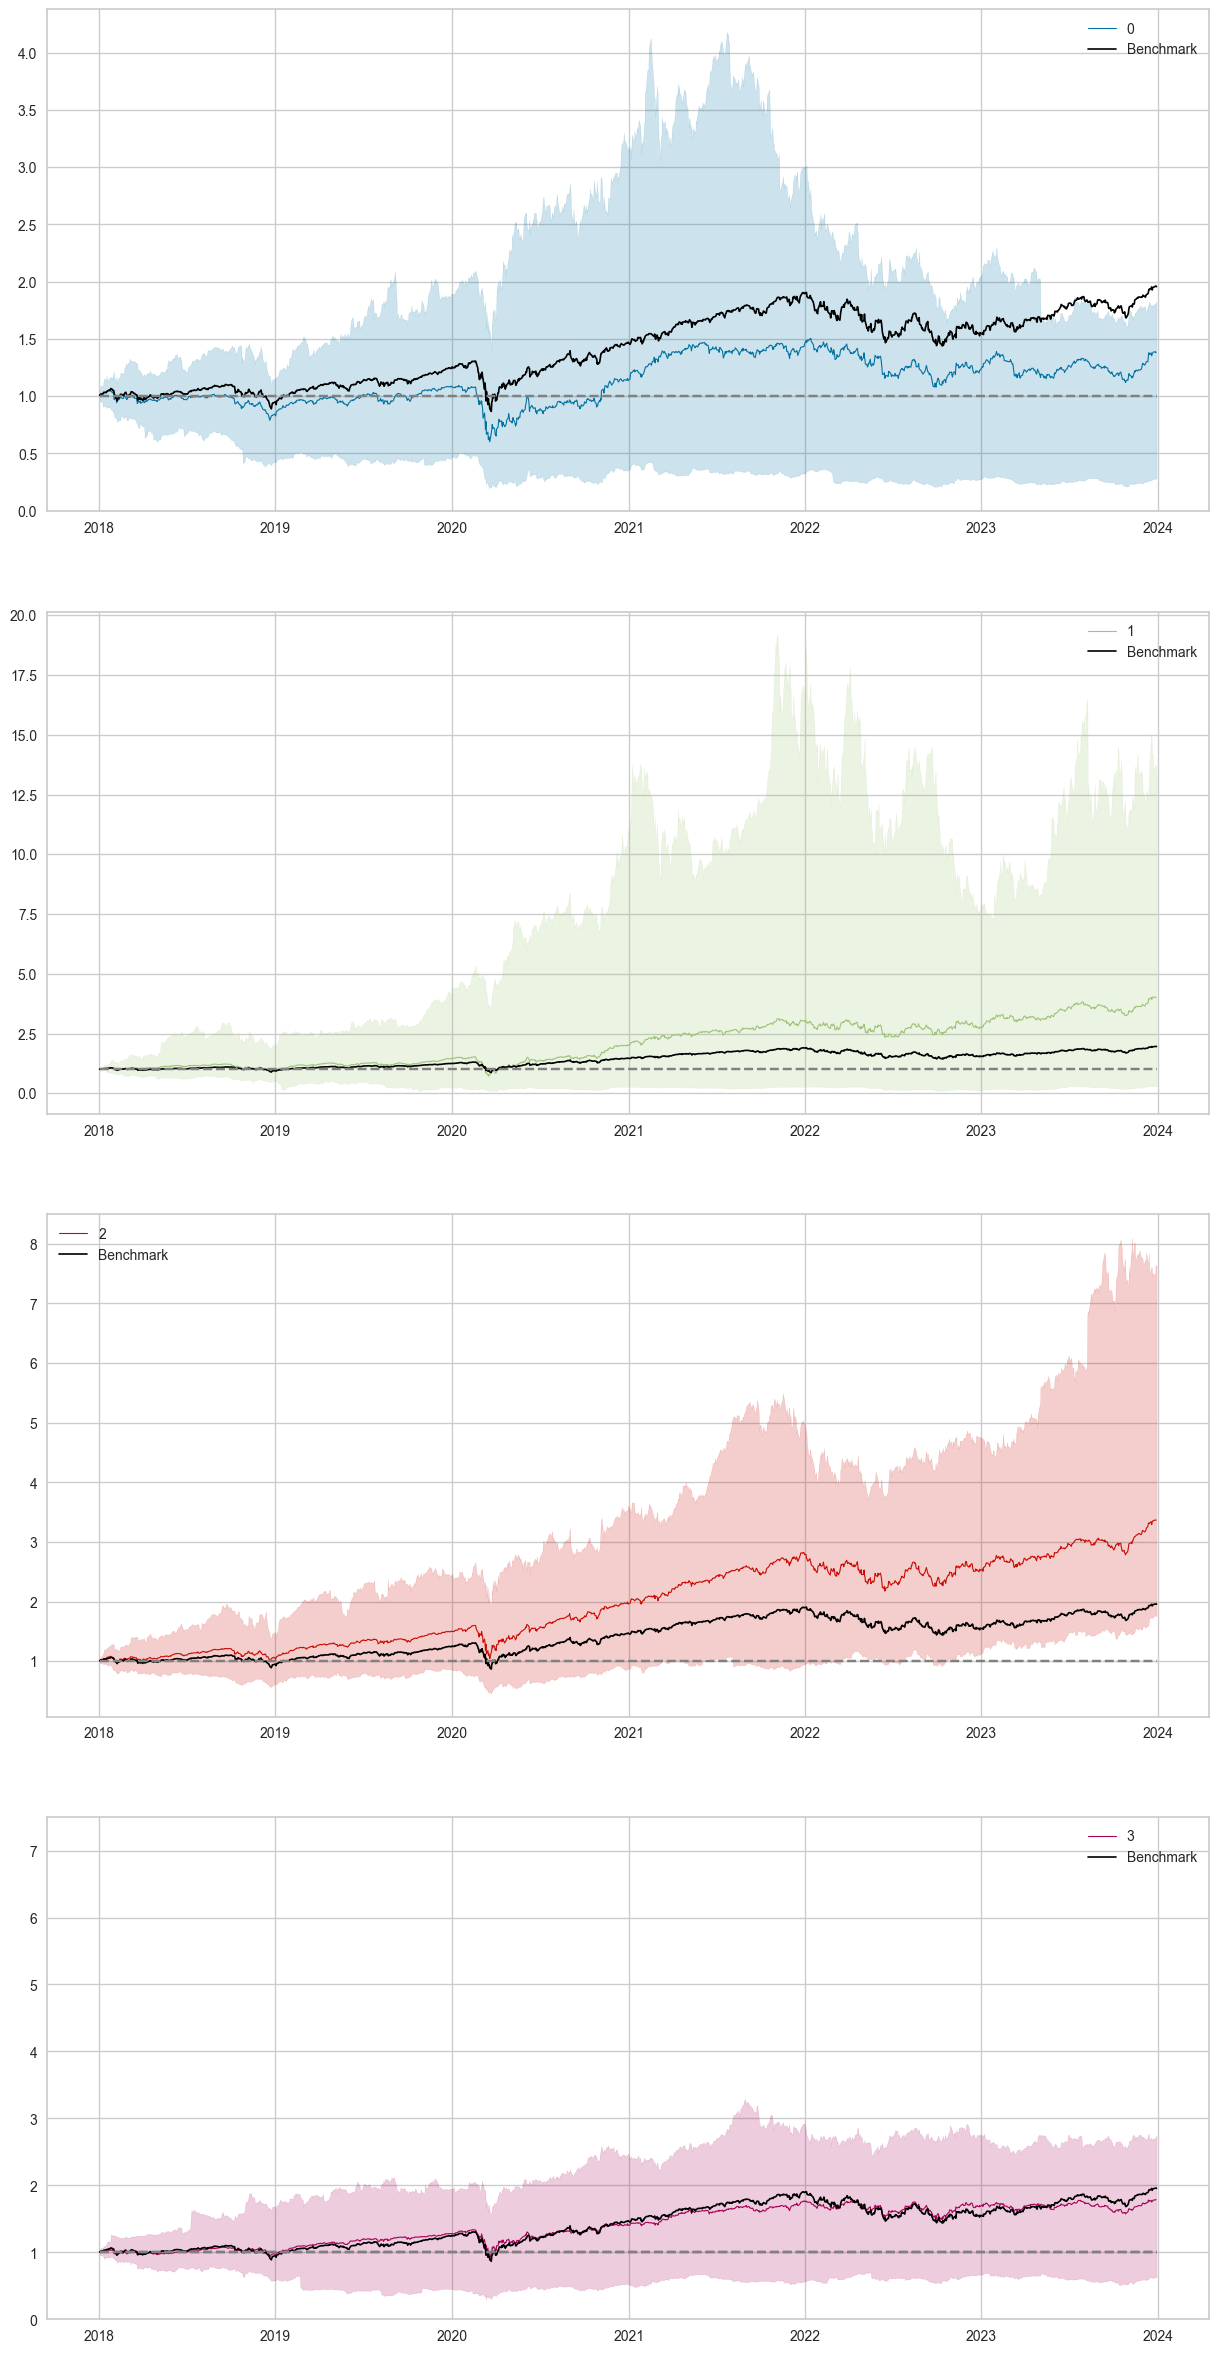

In [26]:
from analysis.data.plotting import portfolio_span
portfolio_span(asset_ret, portfolio_ret, final_dataframe, benchmark, N_SECTORS)

In [28]:
import analysis.data.dataframe_creation as dataframe_creation
importlib.reload(dataframe_creation)
from analysis.data.dataframe_creation import create_portfolio_clustered
sd_test = ed
ed_test = "2025-01-10"
portfolio_ret_t, asset_ret_t = create_portfolio_clustered(sd_test, ed_test, final_dataframe,
                                                           list(final_dataframe["Ticker"]), w="Volatility")

[*********************100%***********************]  483 of 483 completed


Null values: False
Null values: False
Cluster Portfolios based on volatility


In [29]:
benchmark_t = yf.download(tickers="SPY", start=sd_test, end=ed_test, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


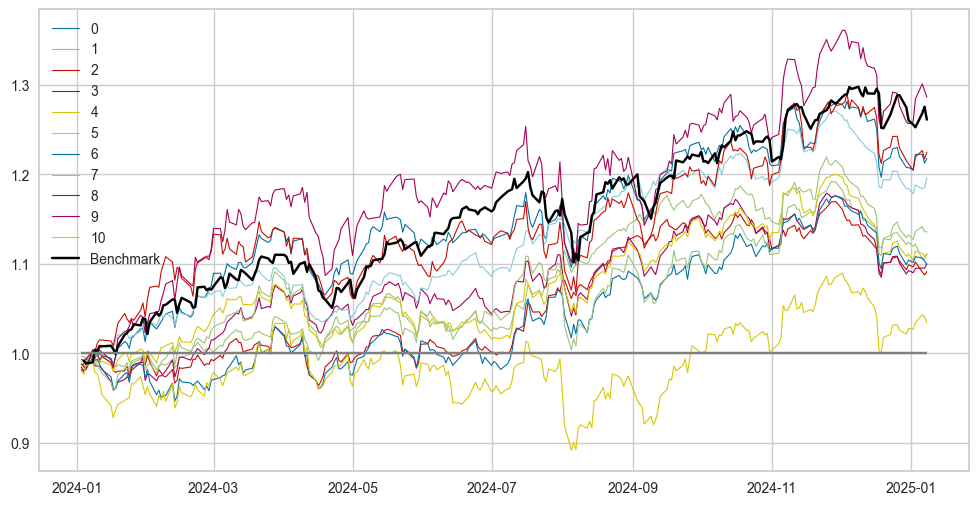

In [30]:
from analysis.data.plotting import portfolio_evolution_time
portfolio_evolution_time(portfolio_ret_t.reset_index(), benchmark_t.reset_index())

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2024-01-03  2024-01-03
End Period                 2025-01-08  2025-01-08
Risk-Free Rate             2.0%        2.0%
Time in Market             100.0%      100.0%

Cumulative Return          19.38%      26.32%
CAGR﹪                     19.04%      25.84%

Sharpe                     1.32        1.73
Prob. Sharpe Ratio         87.66%      93.75%
Smart Sharpe               1.24        1.62
Sortino                    1.93        2.5
Smart Sortino              1.81        2.34
Sortino/√2                 1.37        1.77
Smart Sortino/√2           1.28        1.66
Omega                      1.24        1.24

Max Drawdown               -6.72%      -8.41%
Longest DD Days            101         64
Volatility (ann.)          12.25%      12.58%
R^2                        0.82        0.82
Information Ratio          -0.07       -0.07
Calmar                     2.83        3

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-12-02,2024-12-19,2025-01-08,37,-6.722758,-6.569796
2,2024-07-17,2024-08-05,2024-08-19,33,-6.104070,-5.914650
3,2024-04-01,2024-04-19,2024-07-11,101,-6.096787,-5.899873
4,2024-09-03,2024-09-06,2024-09-16,13,-3.834008,-2.706015
5,2024-10-15,2024-10-31,2024-11-06,22,-3.192383,-2.872852


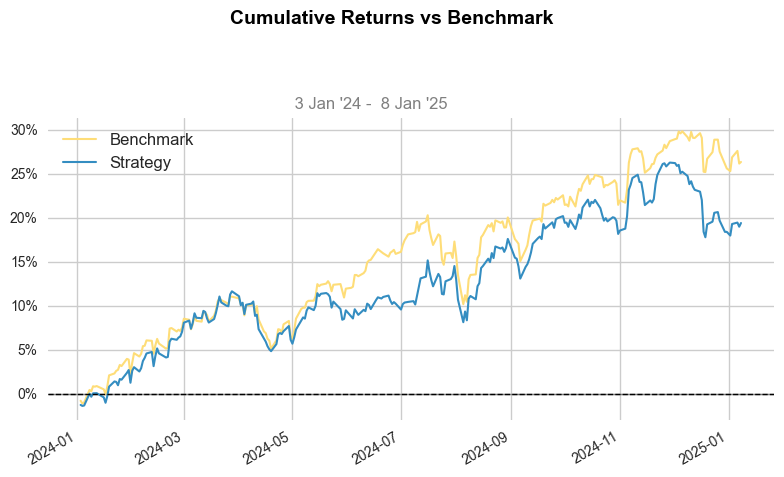

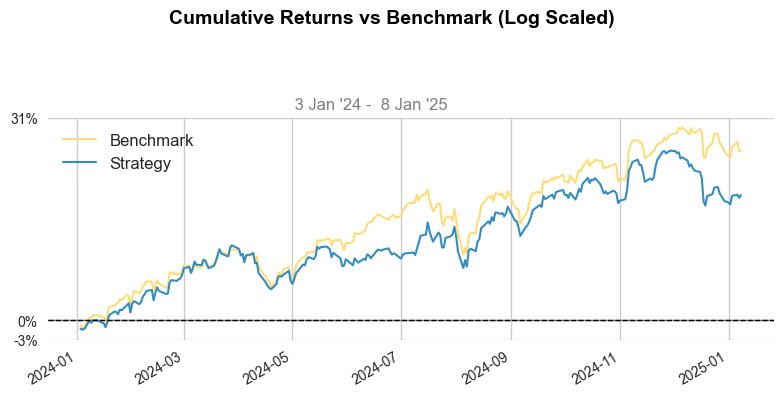

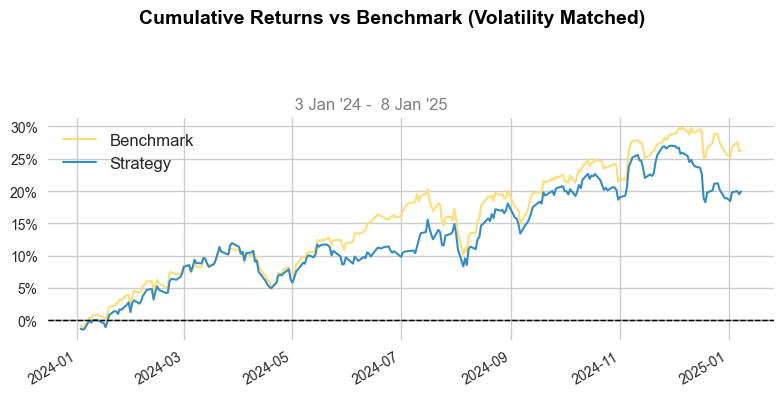

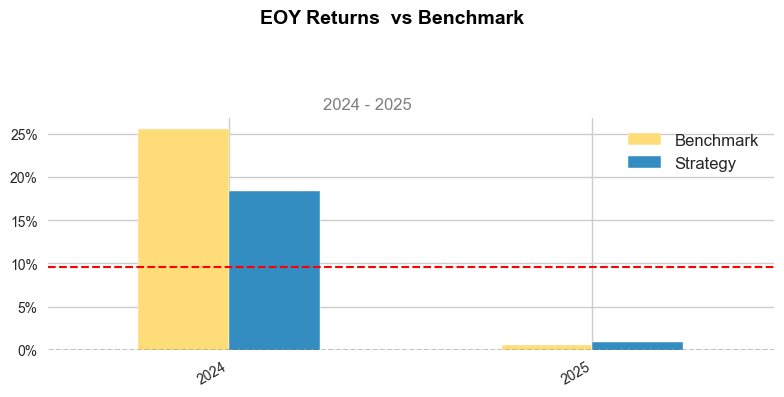

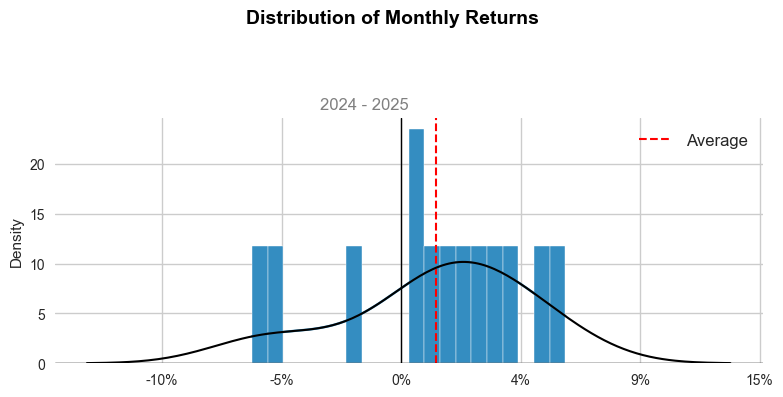

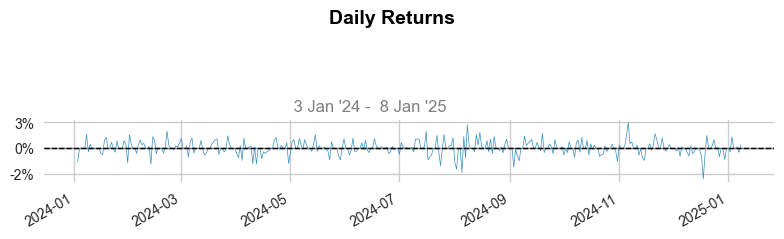

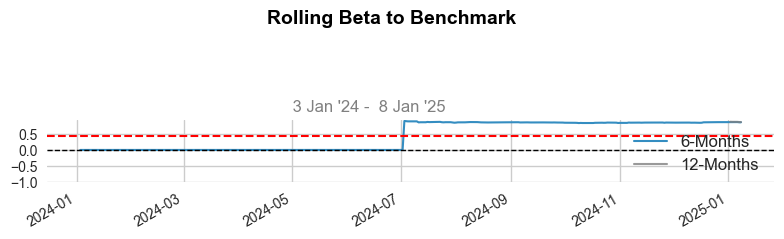

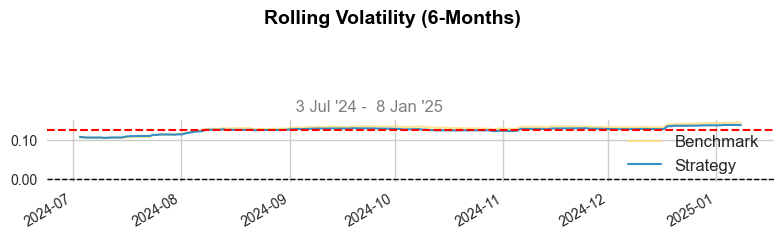

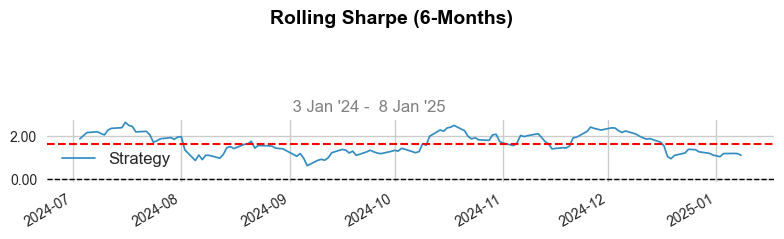

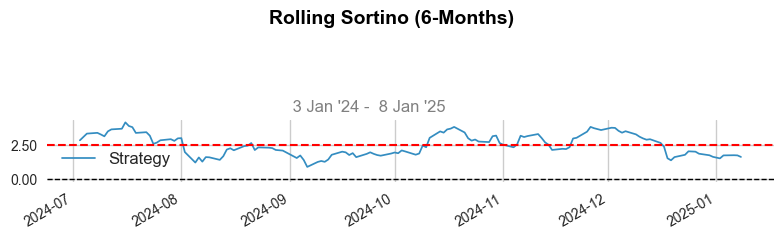

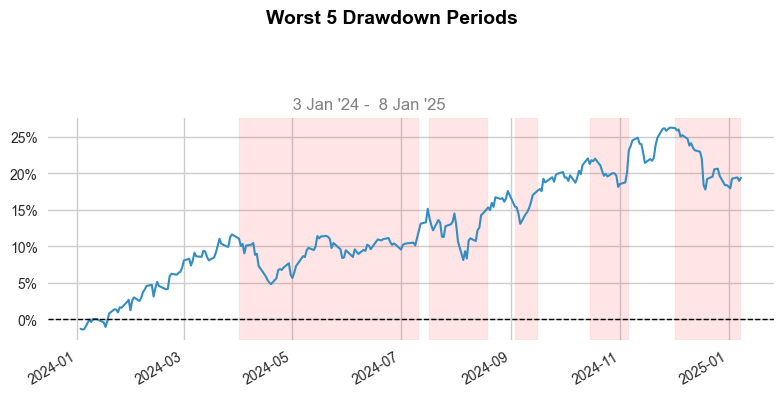

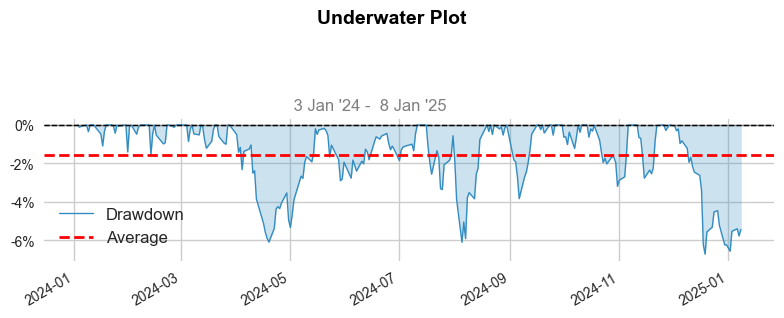

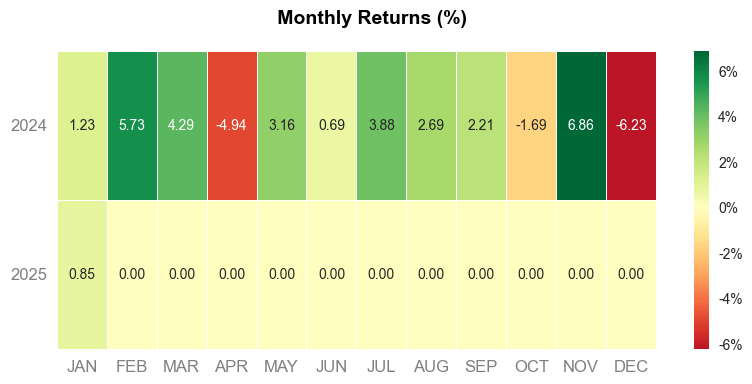

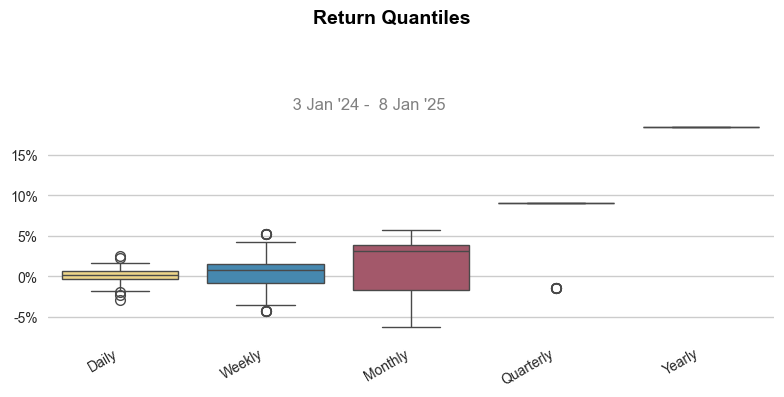

In [32]:
import quantstats as qs
def weights(ratios, cluster, pow, thresh):
    w = np.array(ratios["Sharpe_ratio"] > thresh)*ratios["Sharpe_ratio"]
    ratios["weights"] = np.power(w, pow)
    ratios["weights"] = ratios["weights"]/np.sum(ratios["weights"])
    return ratios.loc[ratios["Sector"] == cluster, "weights"]

returns = np.zeros(len(portfolio_ret_t))
cp = cluster_profile.reset_index()
for i in portfolio_ret_t.columns:
        weight = weights(cp[["Sector", "Sharpe_ratio"]], i, 1, 0.2).values[0]
        returns += weight*portfolio_ret_t[i] 
portfolio_performance = pd.DataFrame(returns).reset_index()

portfolio_performance["Date"] = pd.to_datetime(portfolio_performance["Date"])

# Set "Date" as the index
portfolio_performance.set_index("Date", inplace=True)

# Rename the column for better clarity (optional)
portfolio_performance.columns = ["Returns"]
# Ensure the returns are properly formatted and call the quantstats report
qs.reports.full(portfolio_performance["Returns"], benchmark=benchmark_t.pct_change().dropna(), rf=0.02)